In [1]:
import numpy as np
import math
import plumed
import mdtraj as mdj
import matplotlib.pyplot as plt

In [4]:
%%bash
# compute free energy as a function of simulation time
#kt = 0.0008314 * 300
plumed sum_hills --hills ../HILLS --idw pp.proj --kt 2.5 --mintozero   > out.txt

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/nz/projects/FunnelMetadynamics/packages/plumed2-2.8.1/src/lib/libplumedKernel.so" +++


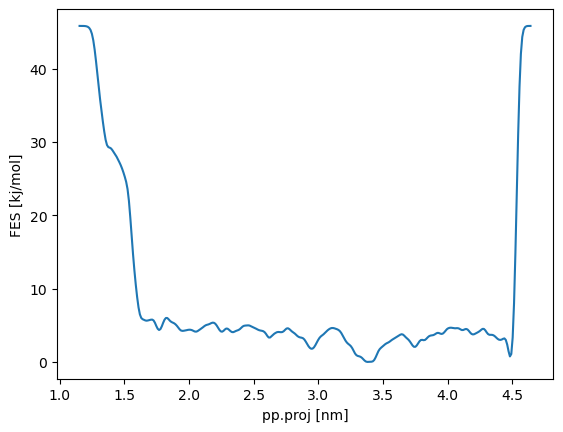

In [67]:
data = plumed.read_as_pandas("fes.dat")
plt.plot(data["pp.proj"],data["projection"])
plt.xlabel("pp.proj [nm]")
plt.ylabel("FES [kj/mol]")
plt.savefig('fes_pp_proj.png')

In [1]:
%%bash
sed '2,2000d' ../COLVAR > COLVAR
plumed --no-mpi driver --plumed reweight_plumed.dat --noatoms > output.txt

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/nz/projects/FunnelMetadynamics/packages/plumed2-2.8.1/src/lib/libplumedKernel.so" +++


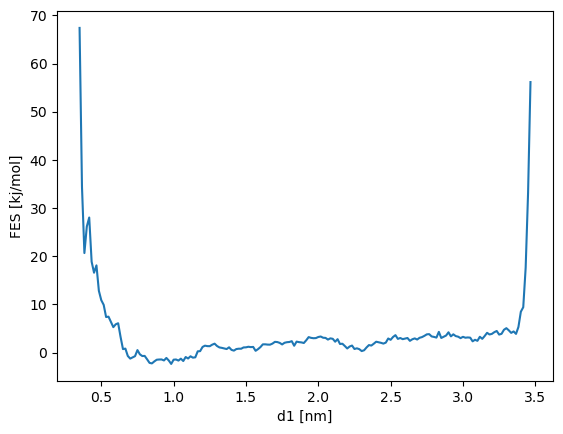

In [63]:
hist = plumed.read_as_pandas('fes_reweighted.dat')
hist.columns    
plt.xlabel("d1 [nm]")
plt.ylabel("FES [kj/mol]")
plt.plot(hist['distance'], hist['ff'])
plt.savefig('d1_fes.png')

In [68]:
# finds the relative free energy of a 1D FES, usually
# of the proj CV
# you will see where this is used in the cell below
def fes_rel(fes_list, fes_all=None, kT=2.49):
    results = []
    for i in fes_list:
        temp = 0
        print("")
        for j in i:
            temp += math.exp(-j / kT)
        results.append(temp)
    total = 0
    if fes_all is None:
        for i in results:
            total += i
    else:
        for i in fes_all:
            total += i
            
    results_2 = []
    for i in results:
        if i > 0:
            results_2.append(-kT * math.log(i / total))
        else:
            results_2.append(np.inf)
    min_res = min(results_2)
    return [i - min_res for i in results_2]

In [5]:
%%bash
plumed sum_hills --hills ../HILLS --kt 2.5 --mintozero  --outfile fes_2d.dat > out.txt

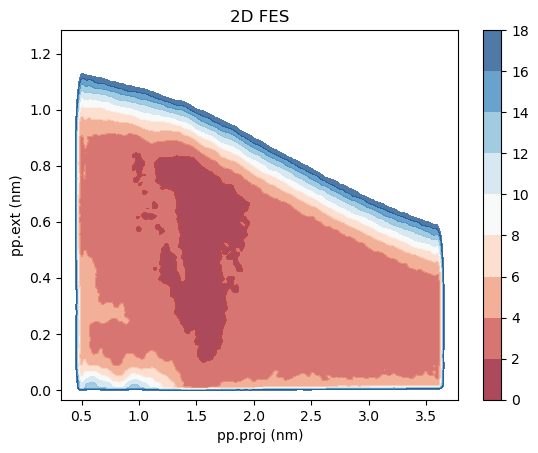

In [8]:
import numpy as np
from scipy.interpolate import griddata
fes=np.loadtxt('fes_2d.dat')

x=fes[:,0]
y=fes[:,1]
z=fes[:,2]/4.168

N=200
xi = np.linspace(x.min(), x.max(), N*2)
yi = np.linspace(y.min(),y.max(), N)
zi = griddata((x, y), (z-z.min()), (xi[None,:], yi[:,None]), method='cubic')

cmap='RdBu'

plt.title('2D FES')

plt.ylabel('pp.ext (nm)')
plt.xlabel('pp.proj (nm)')

plt.contourf(xi, yi, zi, np.arange(0, 20, 2), cmap=cmap, alpha=.75)
plt.colorbar()
plt.savefig("FES_2D.png")